# CA YOUTH PAROLE

In [417]:
"""
STATE: CA
POLICY: Youth Parole for Life-With-Parole Clients
VERSION: V1
DATA SOURCE: CDCR
DATA QUALITY: good
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: October 2022
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 3600x2100 with 0 Axes>

In [418]:
import sys

sys.path.insert(1, "/Users/jazz/Recidiviz/pulse-data")

In [419]:
from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    convert_dates,
)
from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

In [420]:
# # CA_DIRECTORY_PATH = "recidiviz/calculator/modeling/population_projection/state/CA/youth_parole"

# # Get the simulation tag from the model inputs config
# yaml_file_path = "ca_youth_parole_model_inputs.yaml"

# simulation_config = YAMLDict.from_path(yaml_file_path)
# data_inputs = simulation_config.pop_dict("data_inputs")
# simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

# # Convert the timestamps to time_steps (relative ints), with 0 being the most recent
# # date of data (Sept. 2020)
# reference_date = simulation_config.pop("reference_date", float)
# time_step = simulation_config.pop("time_step", float)
# time_converter = TimeConverter(reference_year=reference_date, time_step=time_step)

# Data setup

In [421]:
day_of_data = pd.to_datetime("2022-10-31")
ca_full = pd.read_csv("C006035_2022_10_31.csv")
ca = ca_full

In [422]:
ca["time_served_months"] = ca["Time Served (Months)"]
ca["time_served_years"] = ca.time_served_months / 12

# Calculate prison start date using Time Served field relative to snapshot date
ca["start_date_calc"] = day_of_data - pd.to_timedelta(
    ca.time_served_months * 30.4167, "d"
)

Text(0.0, 1.0, 'Clients by Admission Date and Sentence Type for Current Prison Population')

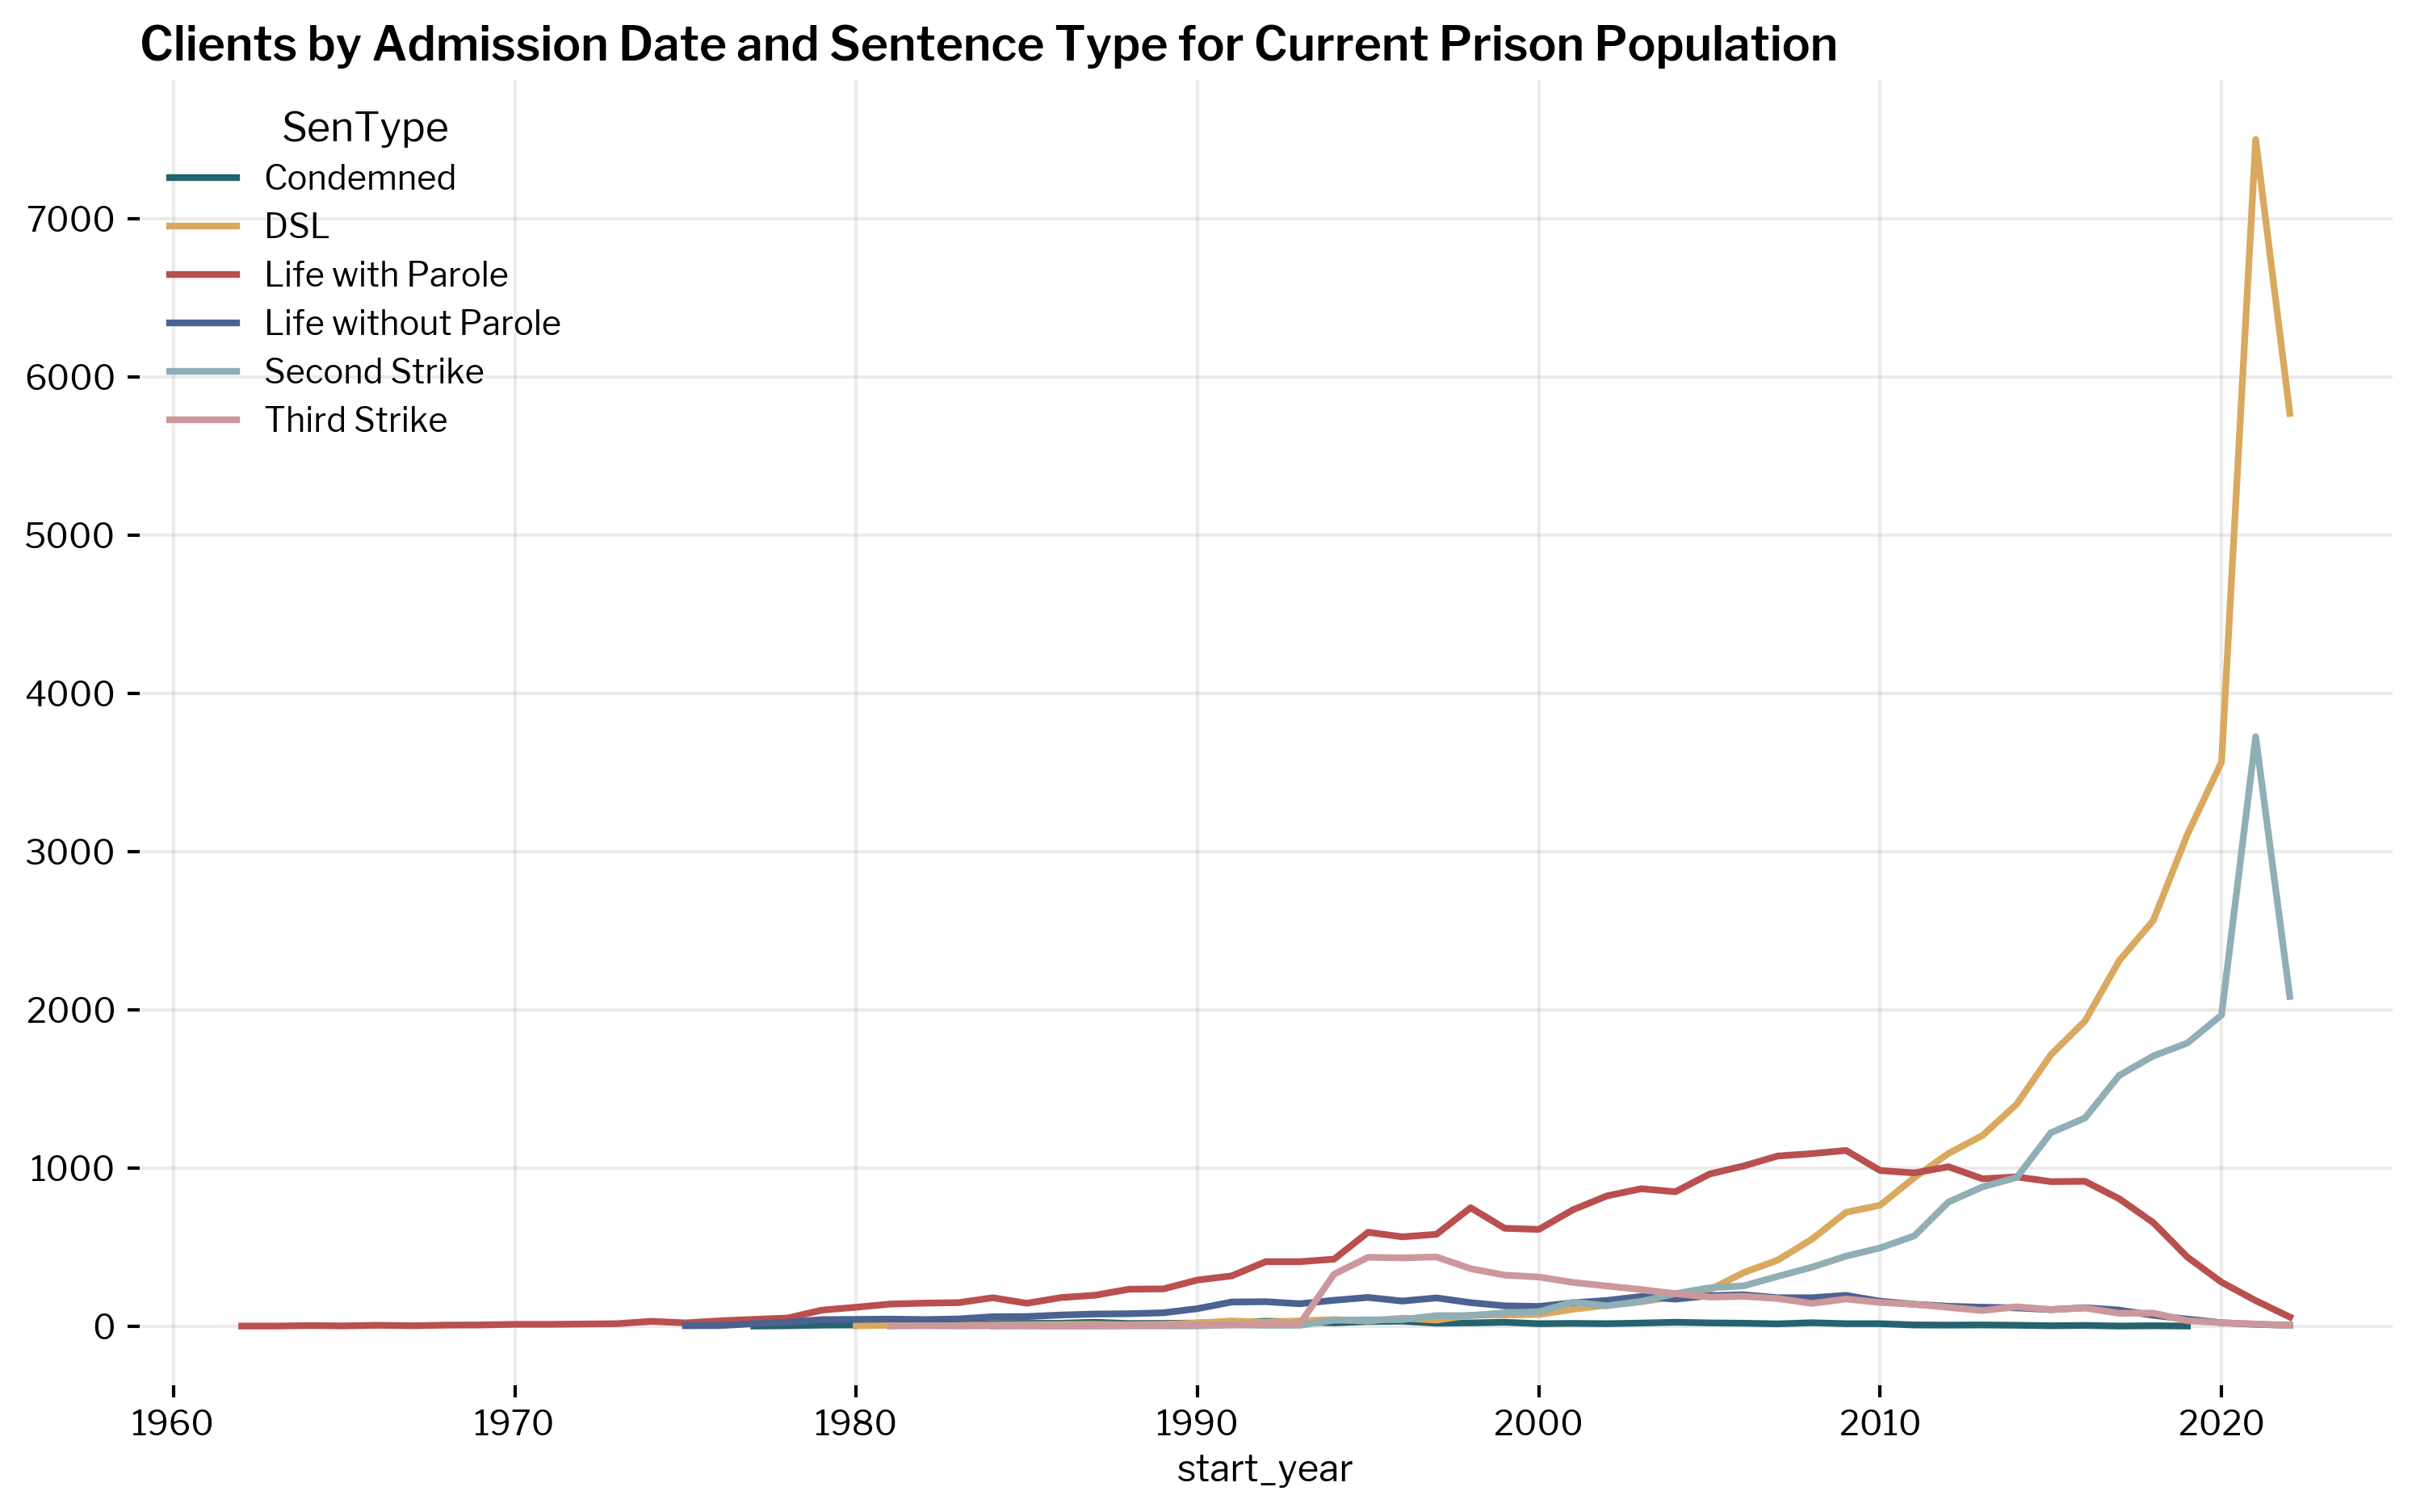

In [423]:
ca["start_year"] = ca.start_date_calc.dt.year
sentypes = (
    ca.groupby(["start_year", "SenType"])[["ID"]]
    .count()
    .reset_index()
    .pivot(index="start_year", columns="SenType", values="ID")
)
# sentypes.tail(7).to_csv('sentypes_CA.csv')
sentypes.loc[1960:].plot()

plt.title("Clients by Admission Date and Sentence Type for Current Prison Population")

# ca = ca.drop(labels=["start_year"], axis=1)

In [424]:
# Limit eligible group
ca = ca.loc[ca.SenType == "Life with Parole"]
ca = ca.loc[ca["Offense Age"] < 26]
# ca = ca.loc[~ca["Offense Group"].str.contains("Murder 1st")]

In [425]:
ca[["minimum_years", "minimum_months"]] = ca.Minimum.str.extract(
    r"(\d*)Y\s(\d*)M", expand=True
)
ca["minimum_sentence_years"] = ca.minimum_years.astype(float) + (
    ca.minimum_months.astype(float) / 12
)
ca = ca.drop(labels=["minimum_years", "minimum_months"], axis=1)

In [426]:
policy_parole_years = 14
policy_date = pd.to_datetime("2023-07")

In [427]:
def get_parole_eligibility_years(x):
    if x.minimum_sentence_years >= 25:
        return 25
    else:
        return 20

In [428]:
ca["parole_eligibility_years"] = ca.apply(
    lambda x: get_parole_eligibility_years(x), axis=1
)
ca["parole_eligibility_date"] = ca.start_date_calc + pd.to_timedelta(
    ca.parole_eligibility_years * 365.25, "d"
)
ca["parole_eligibility_date_policy"] = ca.start_date_calc + pd.to_timedelta(
    policy_parole_years * 365.25, "d"
)

Text(0.0, 1.0, 'Clients by Admission Date And Current Number of Years to Parole Eligibility')

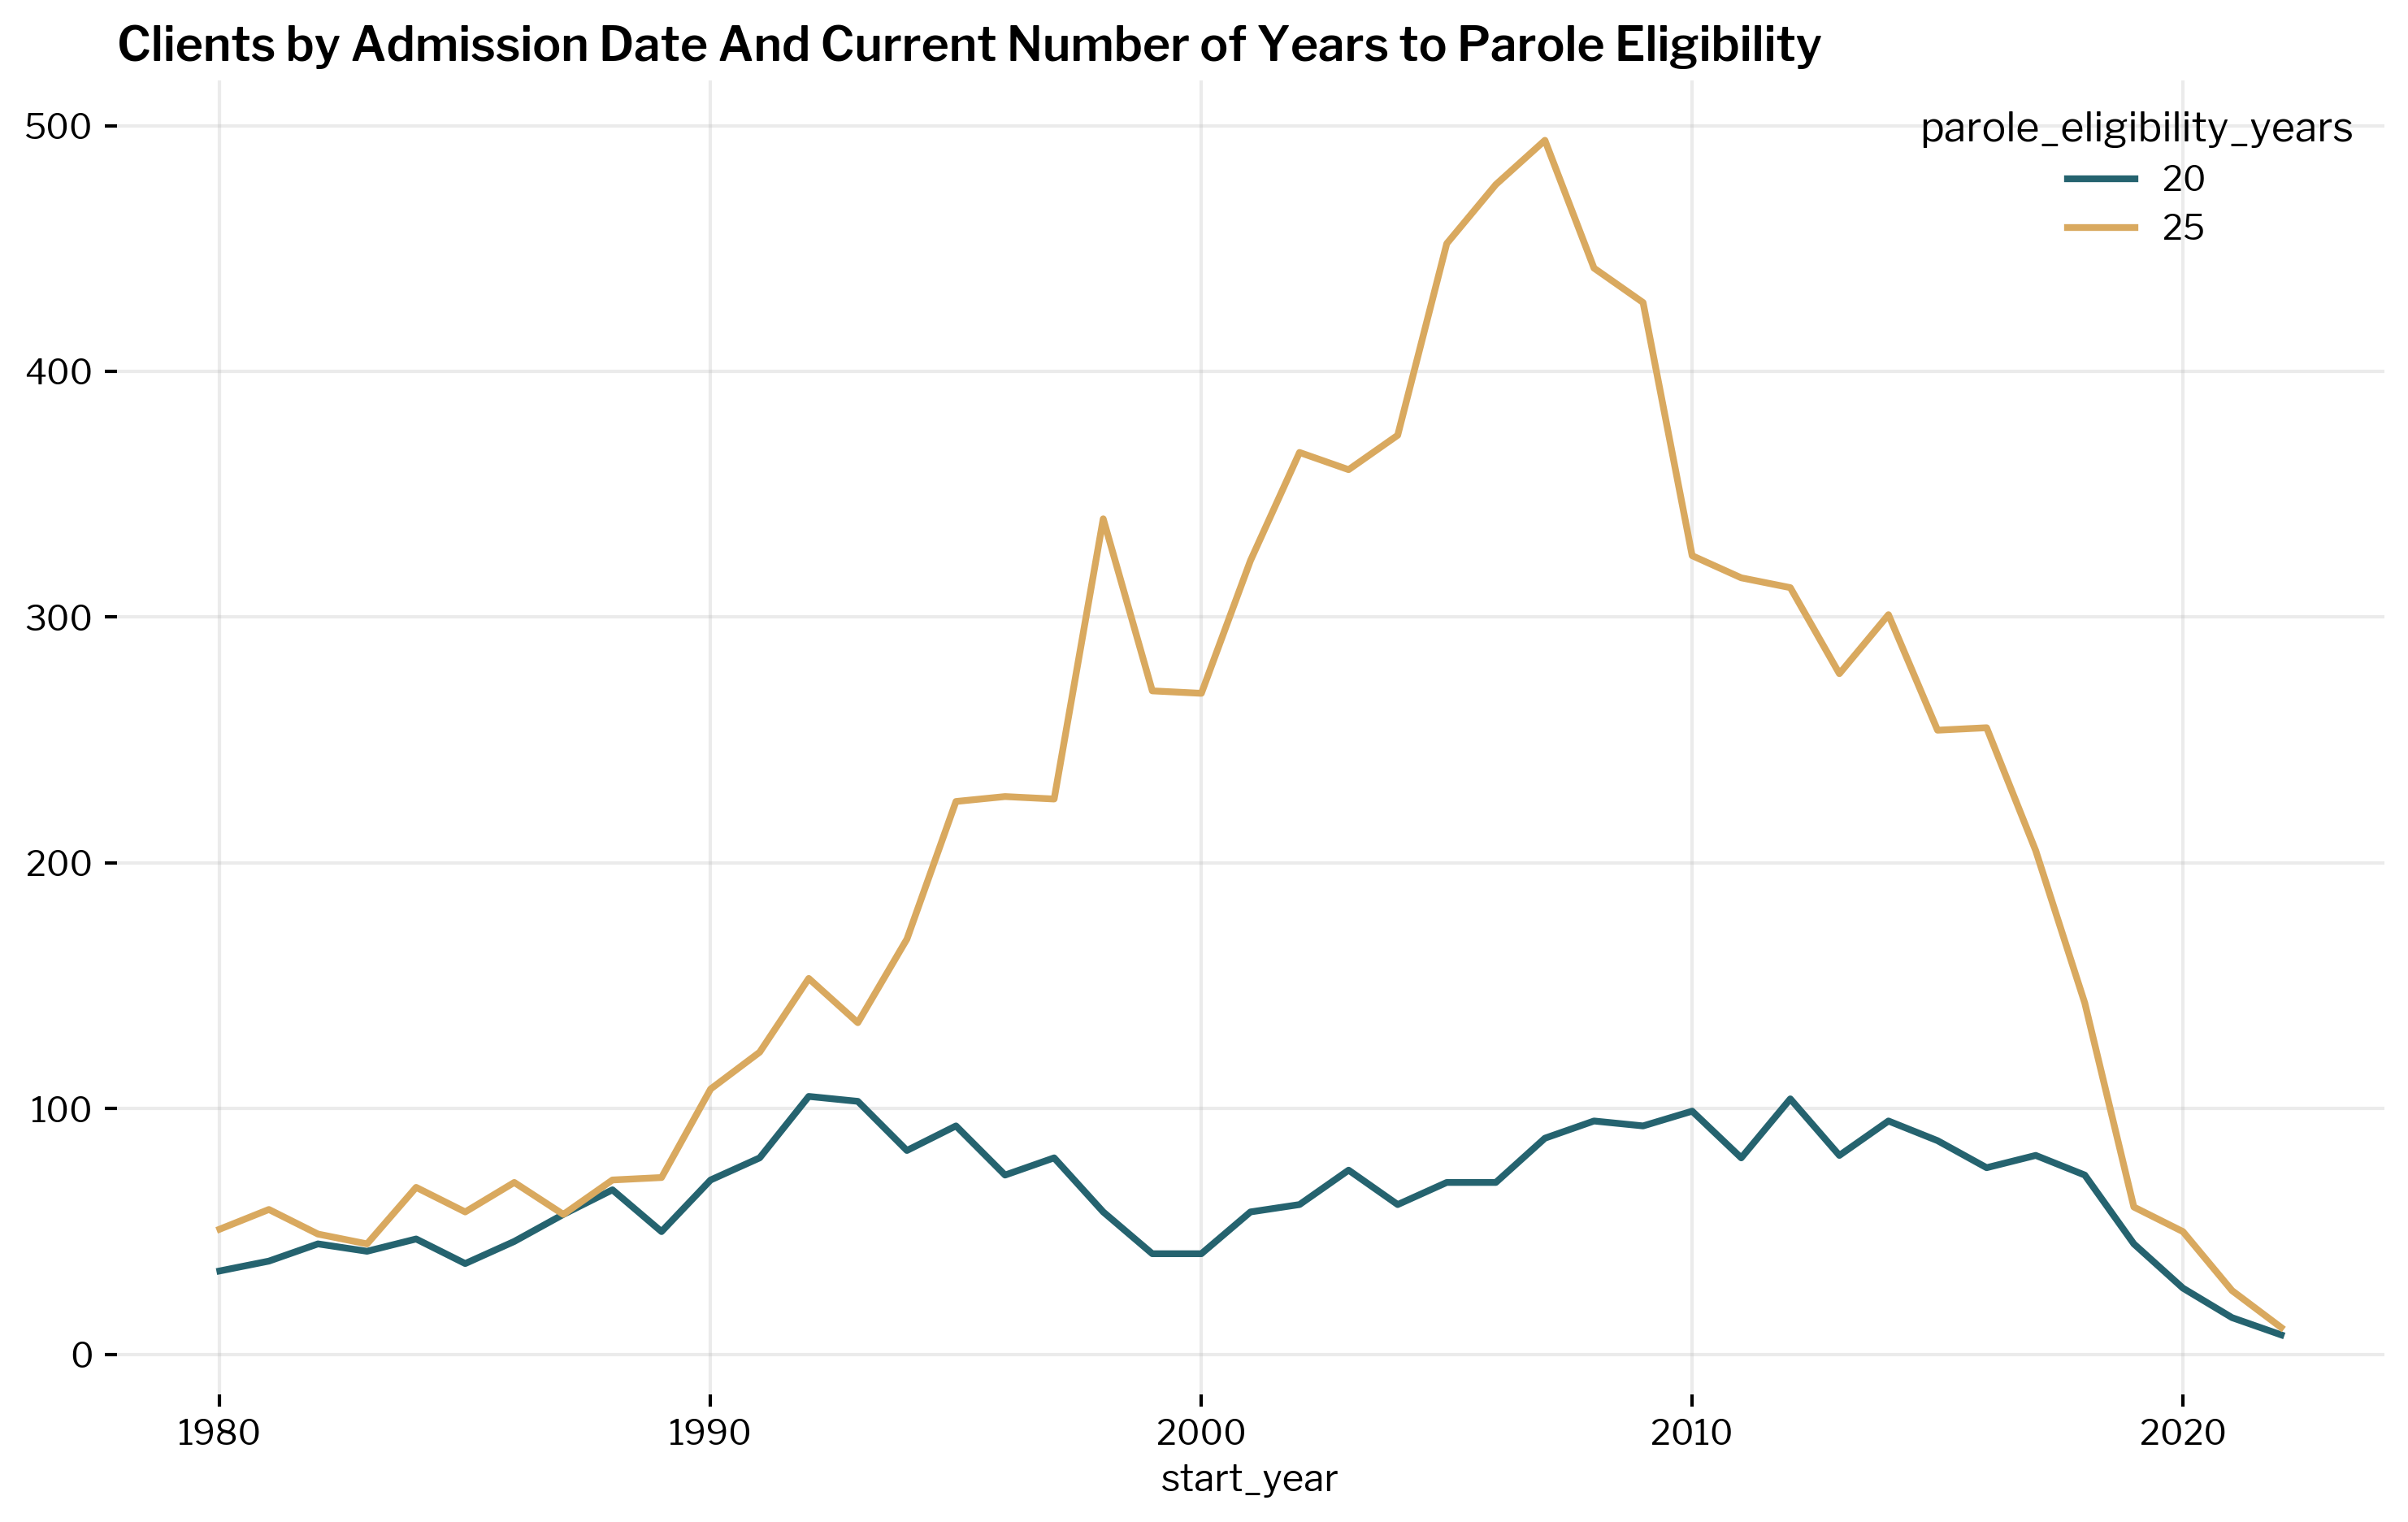

In [429]:
parole_types = (
    (
        ca.groupby(["start_year", "parole_eligibility_years"])[["ID"]]
        .count()
        .reset_index()
        .pivot(index="start_year", columns="parole_eligibility_years", values="ID")
    )
    .loc[1980:]
    .plot()
)
plt.title("Clients by Admission Date And Current Number of Years to Parole Eligibility")

In [430]:
# Further limit eligible group to those with a new parole date
ca = ca.loc[ca.minimum_sentence_years > policy_parole_years]
ca = ca.loc[ca.parole_eligibility_date > policy_date]

In [431]:
ca.parole_eligibility_years.value_counts() / ca.shape[0]

25    0.853089
20    0.146911
Name: parole_eligibility_years, dtype: float64

# Sessions

In [432]:
starting_population = ca.shape[0]
starting_population

8175

In [480]:
hearing_1_grant_rate = 0.17
pflows = pd.DataFrame(
    columns=["hearing_number", "relative_years", "grant_rate"]
).set_index("hearing_number")
pflows.loc["1"] = [0, hearing_1_grant_rate]
# pflows.loc['2'] = [3,.10]
# pflows.loc['3'] = [5,.10]
# pflows.loc['4'] = [7,.10]
pflows.loc["inf"] = [100, 1]
pflows["percent_outflow"] = -((1 - pflows.grant_rate).cumprod()).diff()
pflows.loc["1", "percent_outflow"] = hearing_1_grant_rate
pflows["time_offset"] = pd.to_timedelta(pflows.relative_years * 365.25, "d")
pflows.reset_index(inplace=True)

In [481]:
pflows

,hearing_number,relative_years,grant_rate,percent_outflow,time_offset
0,1,0.0,0.17,0.17,0 days
1,inf,100.0,1.00,0.83,36525 days


In [482]:
cas = pd.merge(
    ca, pflows[["hearing_number", "percent_outflow", "time_offset"]], how="cross"
)

In [483]:
cas["hearing_date_control"] = cas.parole_eligibility_date + cas.time_offset
cas["hearing_date_policy"] = cas.parole_eligibility_date_policy + cas.time_offset

In [484]:
cas["hearing_month_control"] = cas.hearing_date_control.dt.to_period(
    "M"
).dt.to_timestamp()
cas["hearing_month_policy"] = cas.hearing_date_policy.dt.to_period(
    "M"
).dt.to_timestamp()
cas.hearing_month_policy = cas.hearing_month_policy.clip(lower=policy_date)

In [485]:
# cas["time_step_control"] = convert_dates(time_converter, cas.hearing_date_control)
# cas["time_step_policy"] = convert_dates(time_converter, cas.hearing_date_policy).clip(lower=6)

In [486]:
# cas[cas.time_step_control < 360].time_step_control.max()

In [487]:
outflowed_control = (
    cas.groupby("hearing_month_control")
    .percent_outflow.sum()
    #     .reindex(np.arange(0,360))
    .reindex(
        pd.date_range(
            start="2023-01-01", end=cas.hearing_month_control.max(), freq="MS"
        )
    )
    .fillna(0)
    .cumsum()
)
pop_control = starting_population - outflowed_control

In [488]:
outflowed_policy = (
    cas.groupby("hearing_month_policy")
    .percent_outflow.sum()
    #     .reindex(np.arange(0,360))
    .reindex(
        pd.date_range(
            start="2023-01-01", end=cas.hearing_month_control.max(), freq="MS"
        )
    )
    .fillna(0)
    .cumsum()
)
pop_policy = starting_population - outflowed_policy

<AxesSubplot: >

/Users/jazz/.local/share/virtualenvs/pulse-data-WLwBta1t/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


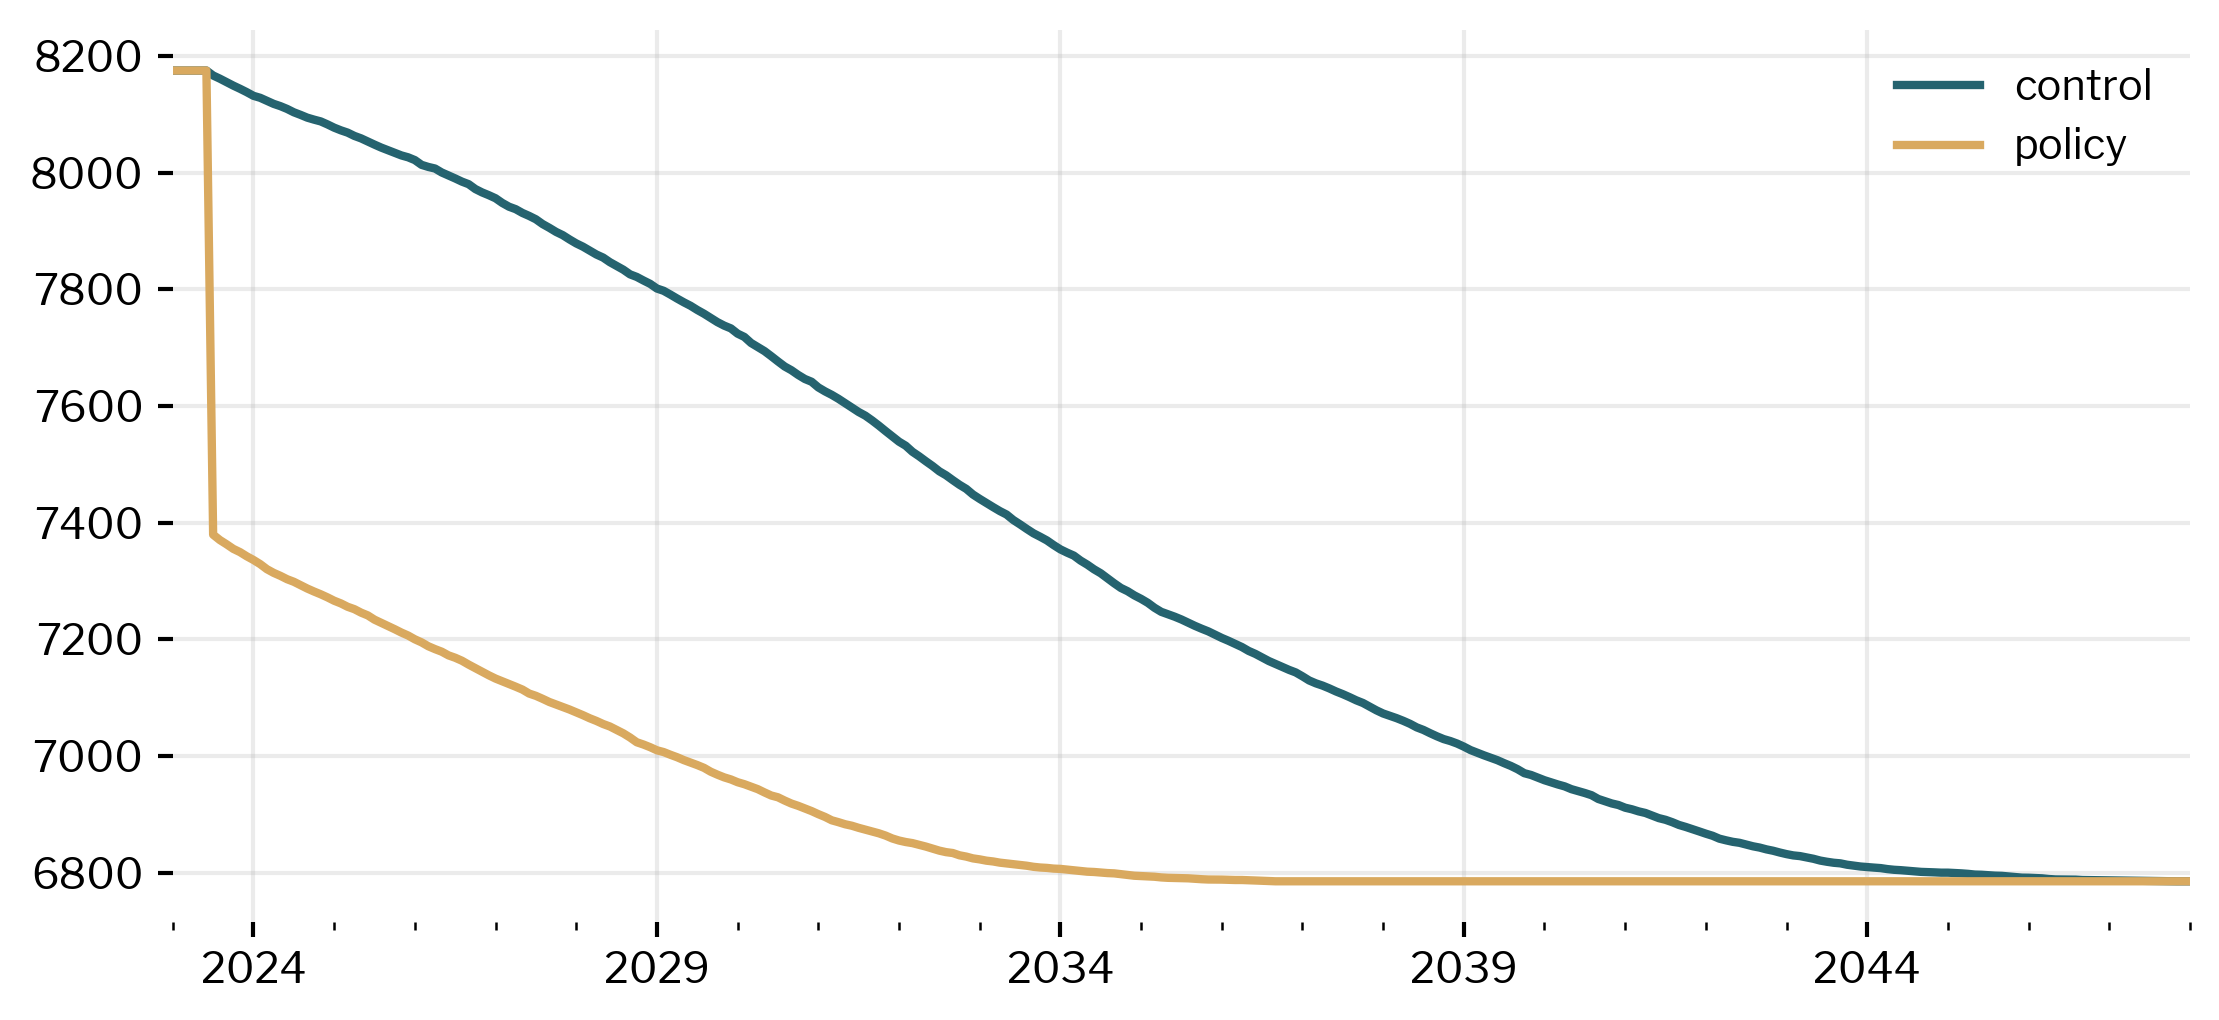

In [489]:
pop_policy = pop_policy.rename("policy").round(2)
pop_control = pop_control.rename("control").round(2)
totals = pd.concat([pop_control, pop_policy], axis=1)
totals.loc[:"2048-01-01"].plot()

In [490]:
totals["difference"] = (totals.control - totals.policy).round()

In [491]:
results = totals.loc[:"2033-01-01"].copy()

In [492]:
results["life_years_out_of_prison"] = (results.difference.cumsum() / 12).round(2)

In [493]:
results

,control,policy,difference,life_years_out_of_prison
2023-01-01,8175.00,8175.00,0.0,0.00
2023-02-01,8175.00,8175.00,0.0,0.00
2023-03-01,8175.00,8175.00,0.0,0.00
2023-04-01,8175.00,8175.00,0.0,0.00
2023-05-01,8175.00,8175.00,0.0,0.00
2023-06-01,8175.00,8175.00,0.0,0.00
2023-07-01,8166.50,7379.40,787.0,65.58
2023-08-01,8161.06,7370.22,791.0,131.50
2023-09-01,8155.11,7362.91,792.0,197.50
2023-10-01,8149.16,7355.09,794.0,263.67


In [494]:
cost_of_prison = 29000
cost_of_parole = 10182
diff_cost = cost_of_prison - cost_of_parole

In [495]:
results["cost_savings_mil"] = results.life_years_out_of_prison * diff_cost / 1000000

In [496]:
results.loc[pd.date_range(start="2023-01-01", end="2033-01-01", freq="YS")]

,control,policy,difference,life_years_out_of_prison,cost_savings_mil
2023-01-01,8175.00,8175.00,0.0,0.00,0.000000
2024-01-01,8131.65,7336.05,796.0,462.50,8.703325
2025-01-01,8077.08,7266.18,811.0,1268.92,23.878537
2026-01-01,8021.49,7200.05,821.0,2084.00,39.216712
2027-01-01,7956.04,7132.73,823.0,2906.00,54.685108
2028-01-01,7878.69,7074.93,804.0,3719.83,69.999761
2029-01-01,7801.34,7009.82,792.0,4516.83,84.997707
2030-01-01,7723.99,6955.08,769.0,5297.00,99.678946
2031-01-01,7631.85,6900.34,732.0,6044.67,113.748600
2032-01-01,7538.86,6855.12,684.0,6754.25,127.101477


In [450]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [451]:
results.loc[pd.date_range(start="2023-01-01", end="2028-01-01", freq="YS")][
    ["control", "policy"]
].reset_index().dtypes

index      datetime64[ns]
control           float64
policy            float64
dtype: object

In [452]:
results.index = [
    pd.to_datetime(date, format="%Y-%m-%d").date() for date in results.index
]

In [453]:
results.reset_index().dtypes

index                        object
control                     float64
policy                      float64
difference                  float64
life_years_out_of_prison    float64
cost_savings_mil            float64
dtype: object

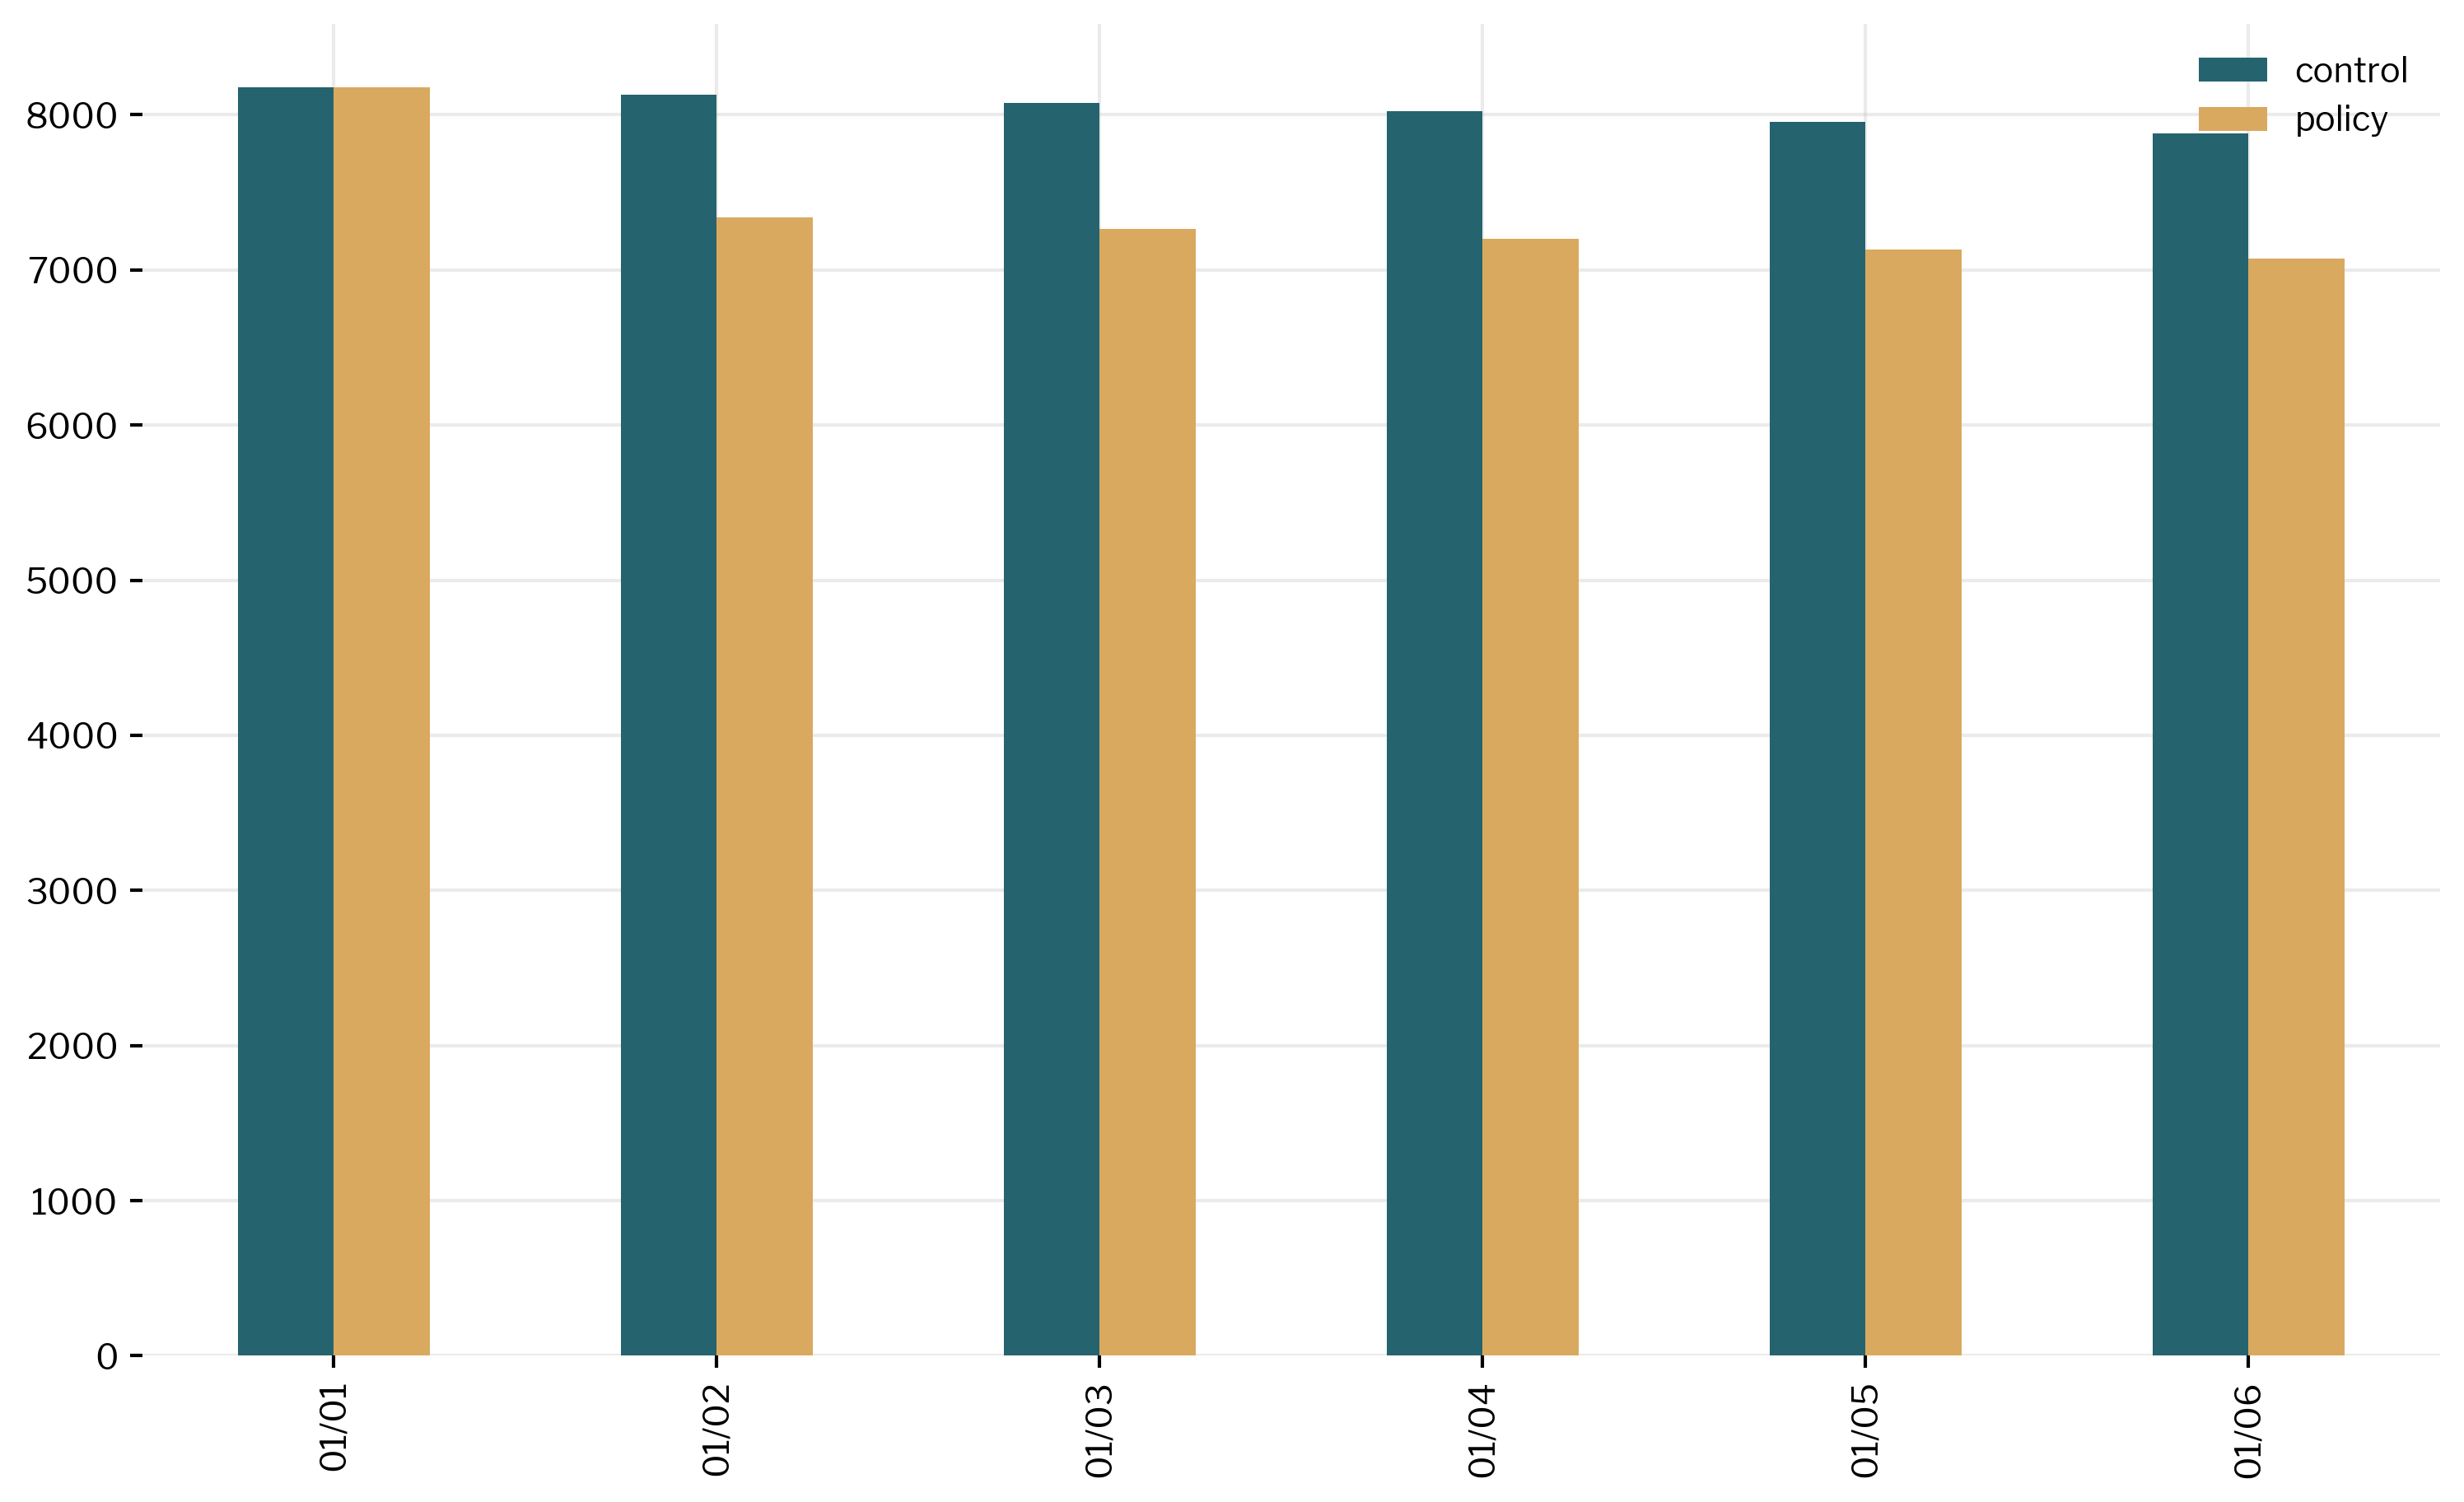

In [454]:
ax = results.loc[pd.date_range(start="2023-01-01", end="2028-01-01", freq="YS")][
    ["control", "policy"]
].plot.bar()
# ax.xaxis.set_major_locator(mdates.YearLocator(interval=1))
# ax.xaxis.set_major_formatter('{x} km')
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))

/Users/jazz/.local/share/virtualenvs/pulse-data-WLwBta1t/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


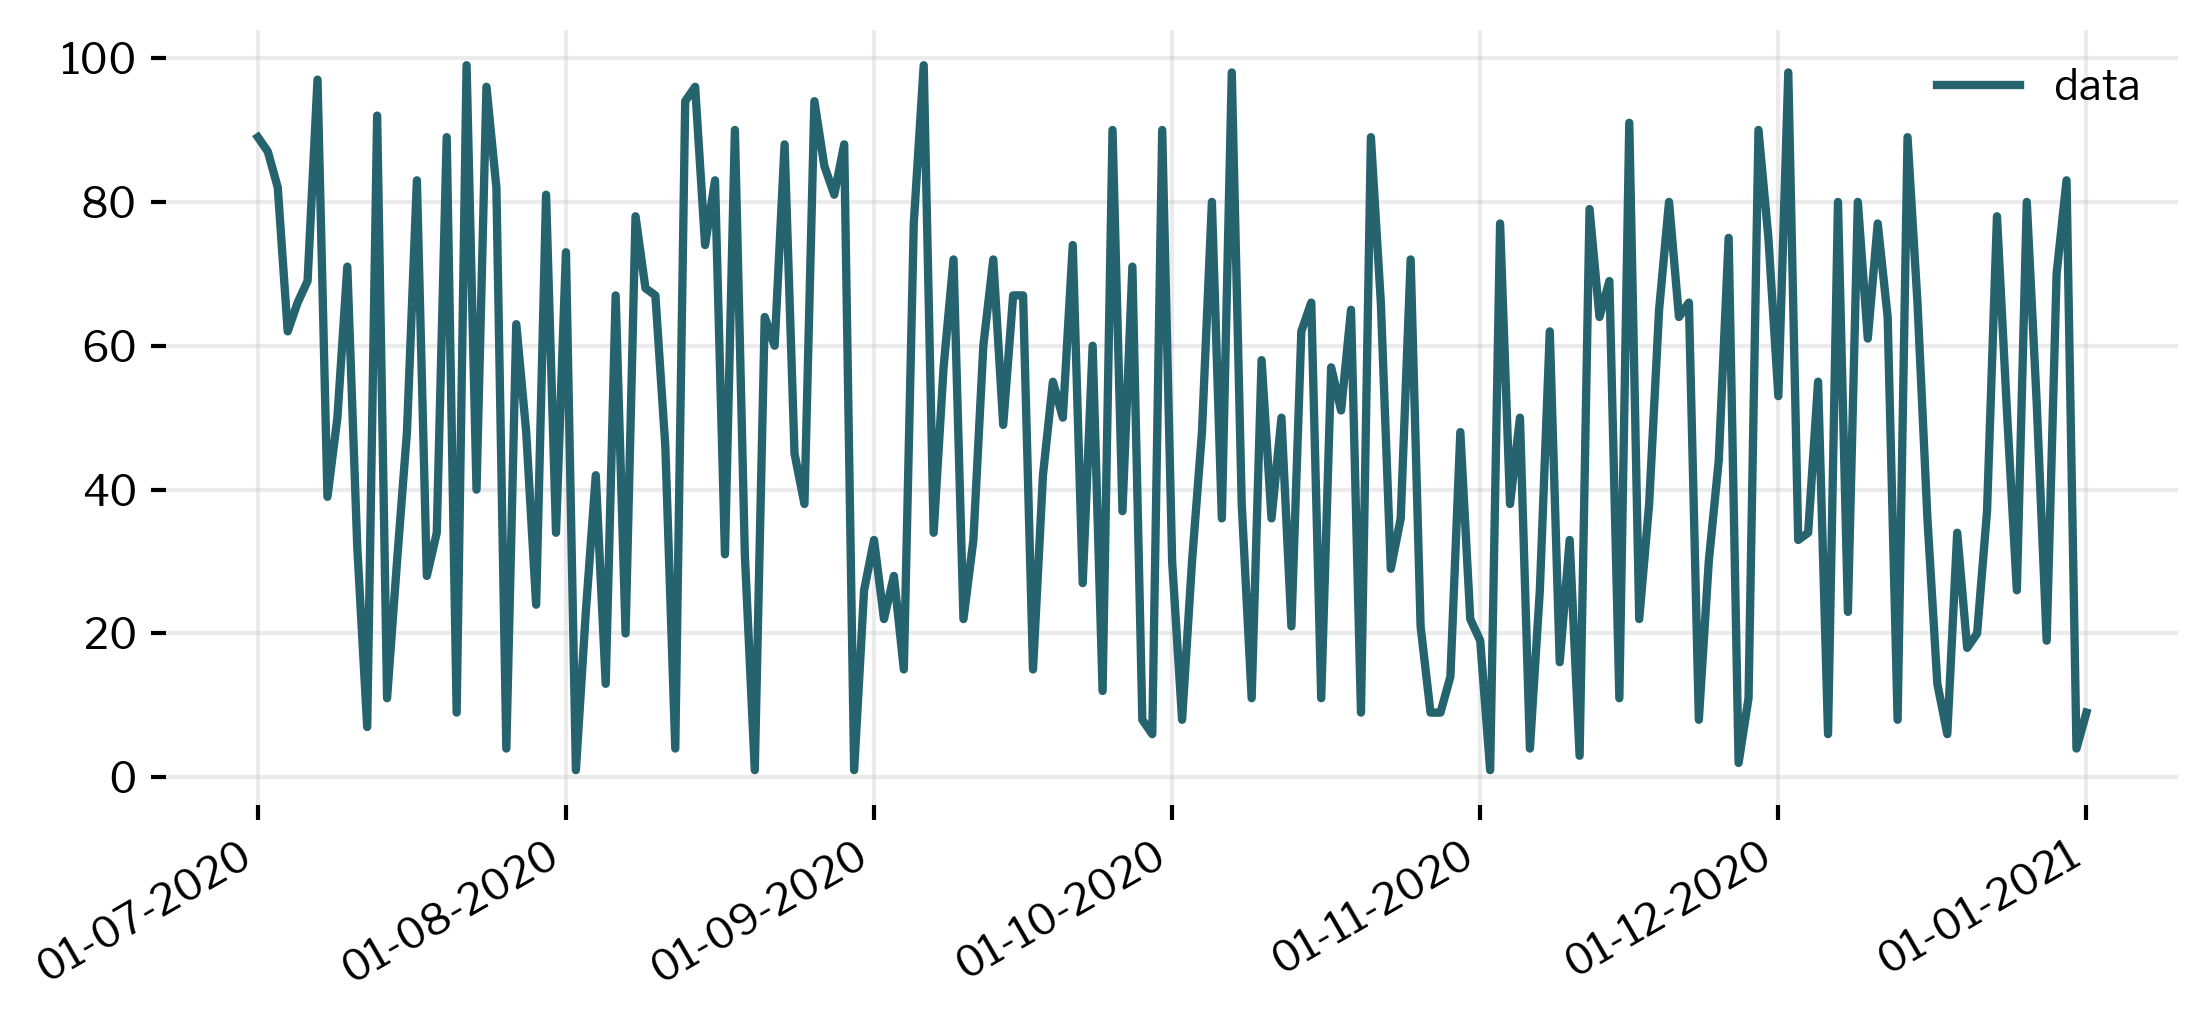

In [455]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

index = pd.date_range(start="2020-07-01", end="2021-01-01", freq="D")
index = [pd.to_datetime(date, format="%Y-%m-%d").date() for date in index]

data = np.random.randint(1, 100, size=len(index))

df = pd.DataFrame(data=data, index=index, columns=["data"])

ax = df.plot()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))

plt.gcf().autofmt_xdate()

plt.show()

In [456]:
results.loc[
    pd.date_range(start="2024-01-01", end="2028-01-01", freq="YS")
].life_years_out_of_prison

2024-01-01     462.50
2025-01-01    1268.92
2026-01-01    2084.00
2027-01-01    2906.00
2028-01-01    3719.83
Name: life_years_out_of_prison, dtype: float64

<AxesSubplot: >

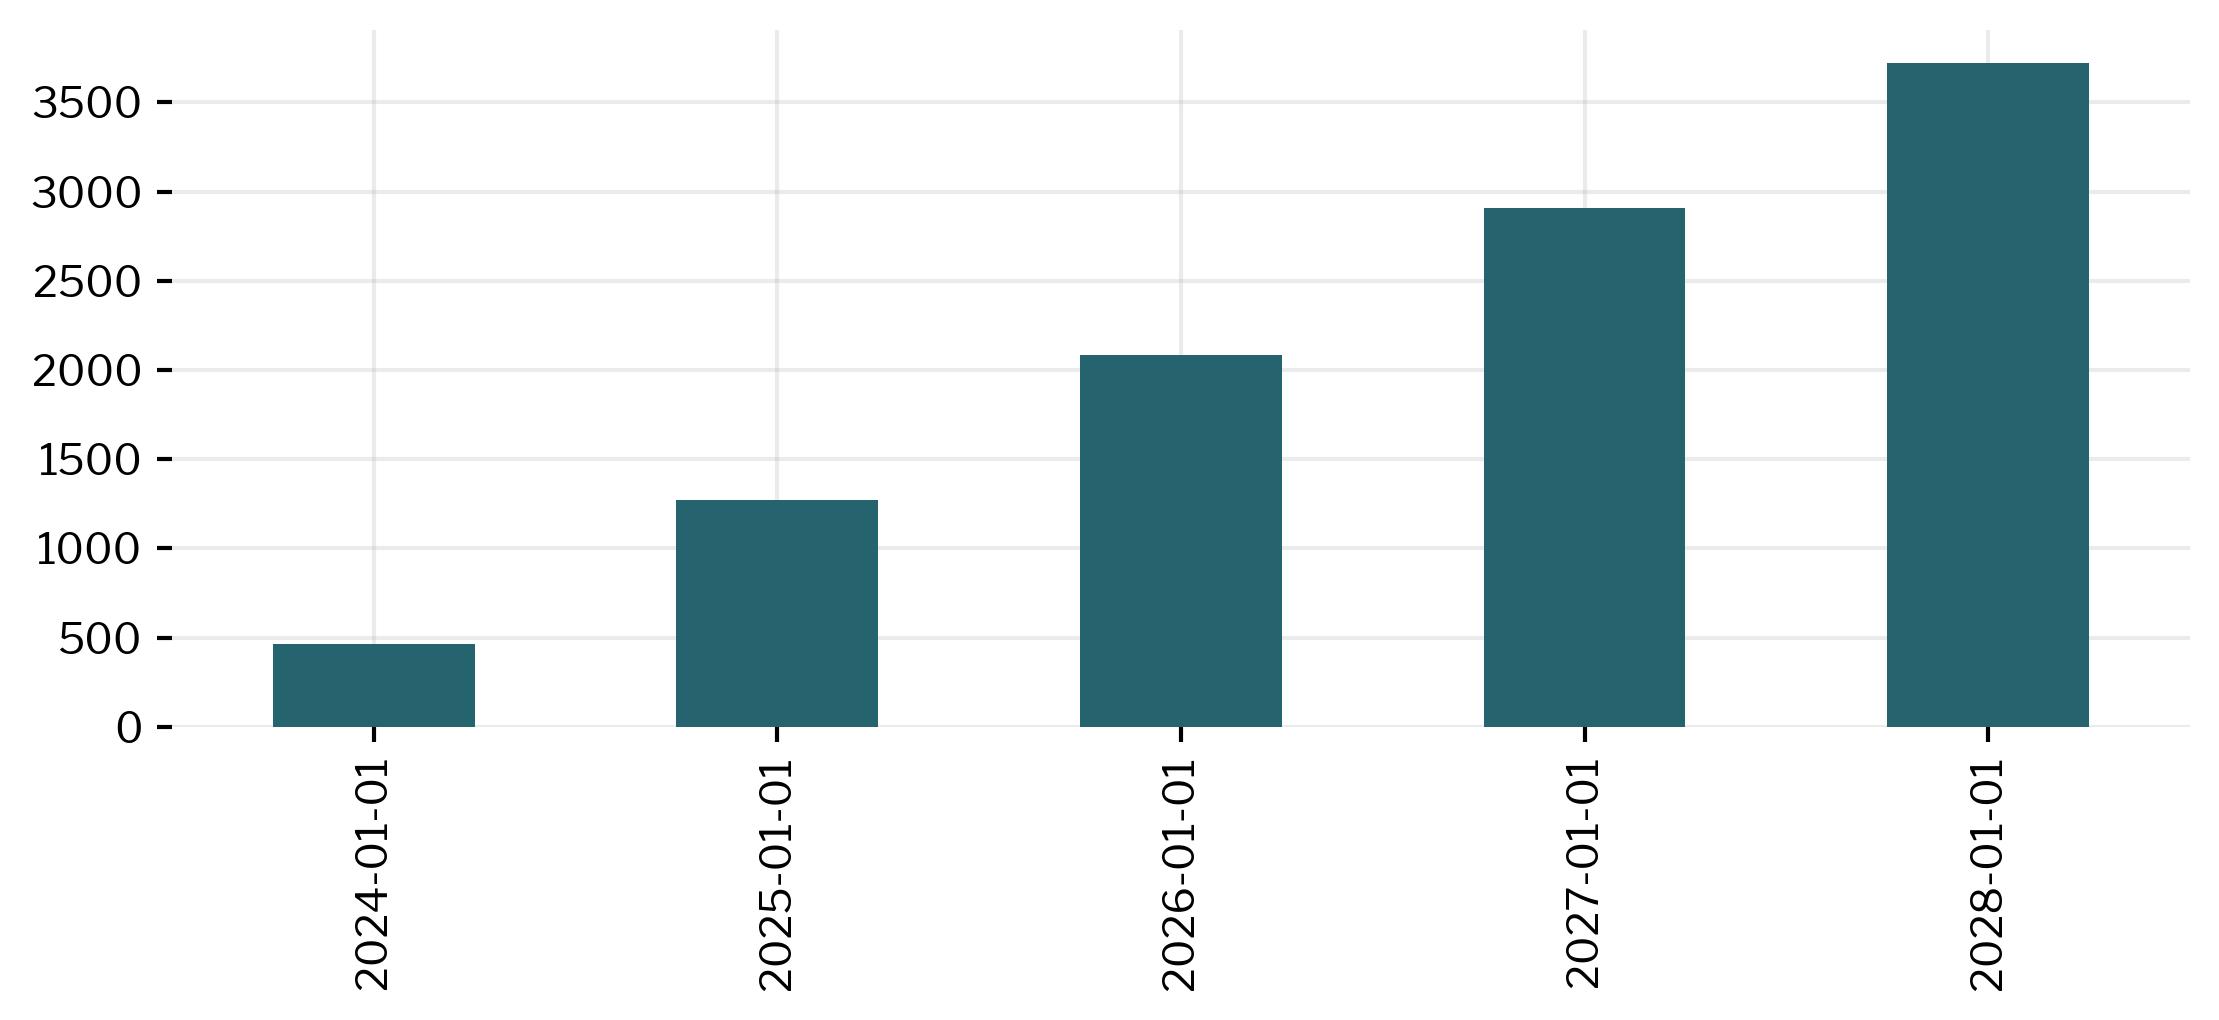

In [457]:
results.loc[
    pd.date_range(start="2024-01-01", end="2028-01-01", freq="YS")
].life_years_out_of_prison.plot.bar()

In [465]:
results.loc[
    pd.date_range(start="2023-01-01", end="2028-01-01", freq="YS")
].cost_savings_mil

2023-01-01     0.000000
2024-01-01     8.703325
2025-01-01    23.878537
2026-01-01    39.216712
2027-01-01    54.685108
2028-01-01    69.999761
Name: cost_savings_mil, dtype: float64

<AxesSubplot: >

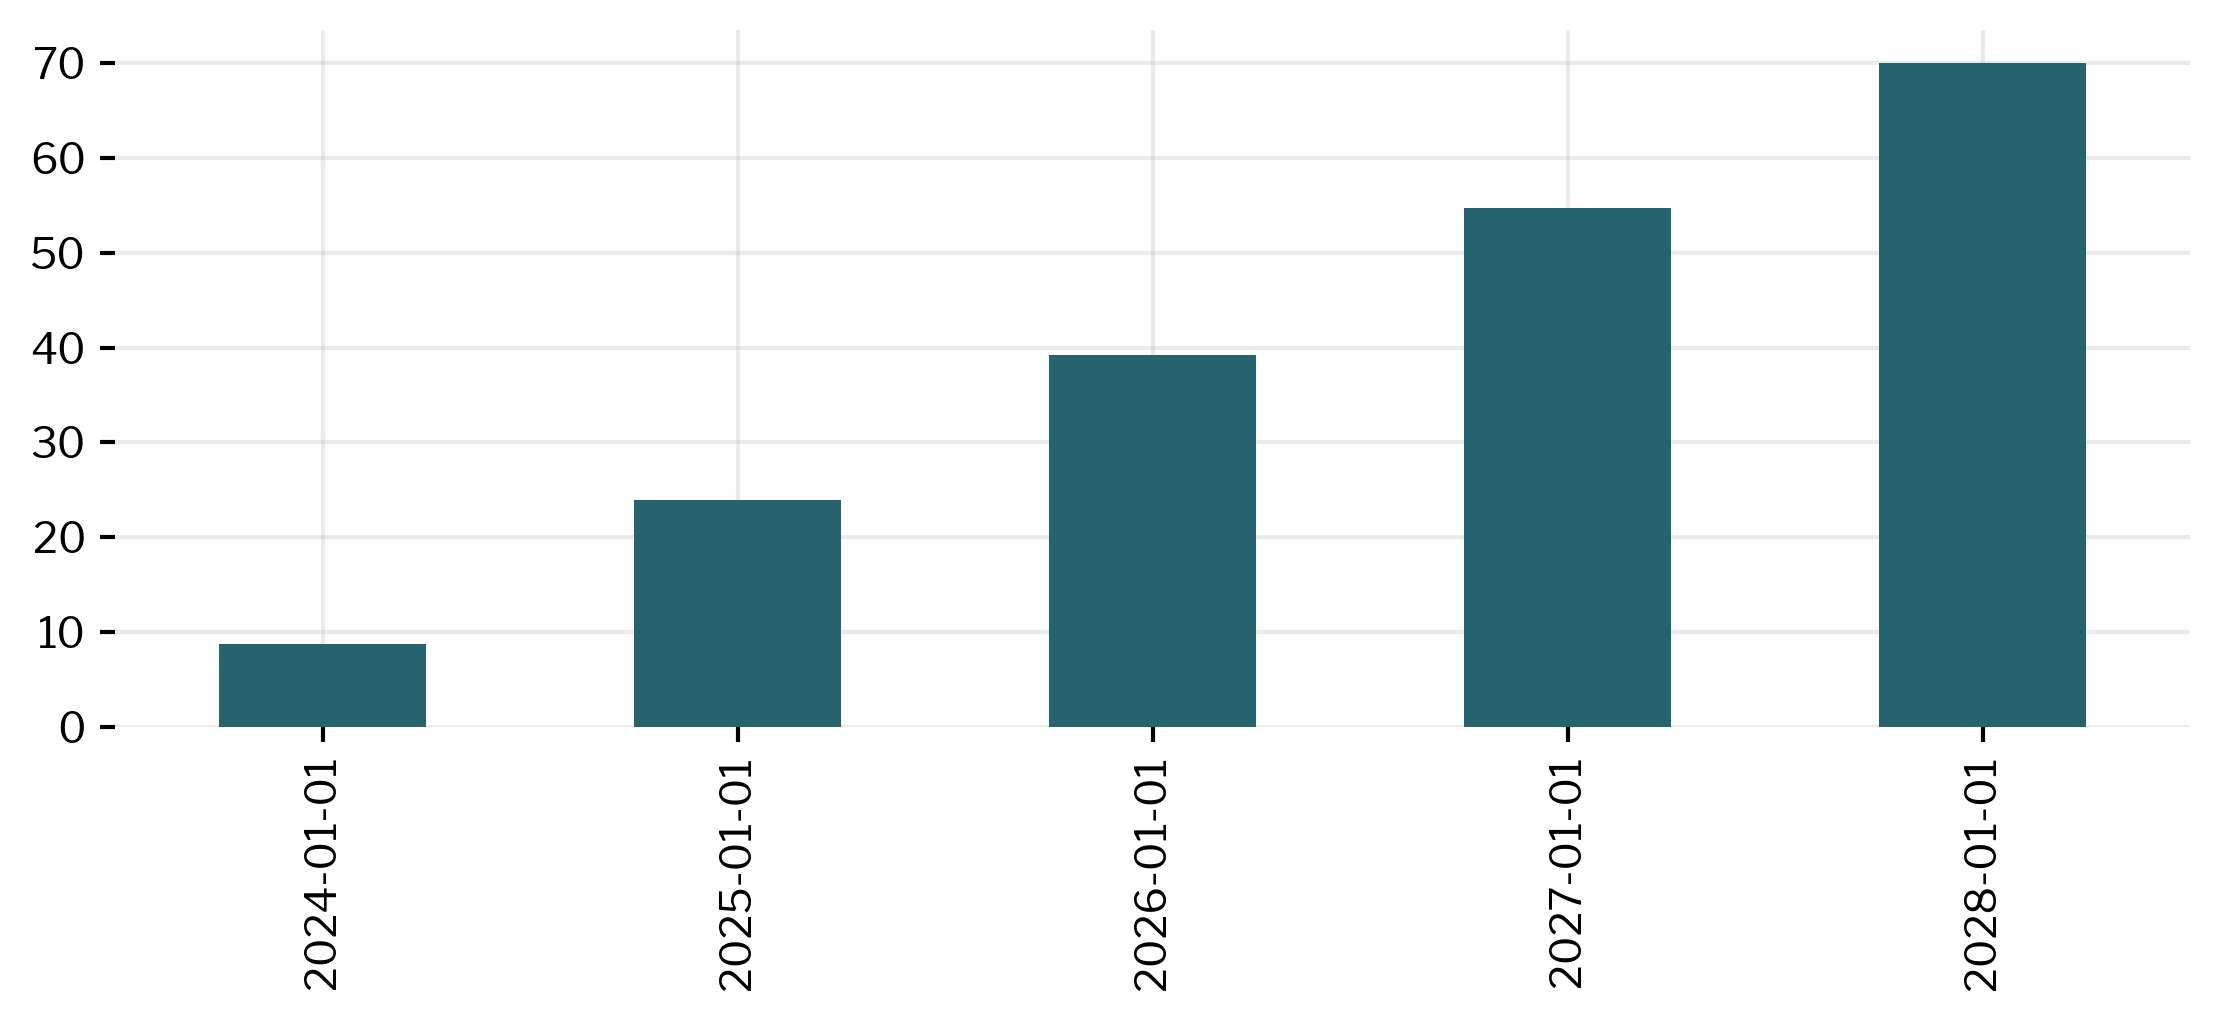

In [459]:
results.loc[
    pd.date_range(start="2024-01-01", end="2028-01-01", freq="YS")
].cost_savings_mil.plot.bar()